# Building graph from the sequences of the runs.

In [130]:
import numpy as np
from tqdm import tqdm as tq
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
# from pyvis.network import Network
from itertools import combinations, chain
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
small = {
    "freq": 4,
    "loc": "data/small/all_poses_freq_4.npy",
    "desc": "data/small/all_feat.npy",
    # "desc": "data/small/results_1/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/small/results_1/groups/labels_sequence.npy",
        "data/small/results_1/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/small/results_1/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/small/results_1/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_feature@5/small_features.npy",
        "seq_desc/r19_gem_cat_feature@5/small_features.npy",
    ]
}

In [3]:
qsmall = {
    "freq": 3,
    "loc": "data/qsmall/all_poses_freq_3.npy",
    "desc": "data/qsmall/all_feat.npy",
    # "desc": "data/qsmall/results/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/qsmall/results/groups/labels_sequence.npy",
        "data/qsmall/results/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/qsmall/results/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/qsmall/results/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_feature@5/qsmall_features.npy",
        "seq_desc/r19_gem_cat_feature@5/qsmall_features.npy",
    ]
}

In [4]:
rsmall = {
    "freq": 3,
    "loc": "data/rsmall/all_poses_freq_3.npy",
    "desc": "data/rsmall/all_feat.npy",
    # "desc": "data/rsmall/results/all_pca_feat.npy",
    "non_gr_seqs": [
        "data/rsmall/results/groups/labels_sequence.npy",
        "data/rsmall/results/groups/avg_pca_seq_labels_sequence.npy",
    ],
    "seqs": [
        "data/rsmall/results/groups/r18l4_seqvlad_seq_labels_sequence.npy",
        "data/rsmall/results/groups/r18l3_gem_cat_seq_labels_sequence.npy",
    ],
    "grp_rep": [
        "seq_desc/r18l4_seqvlad_feature@5/rsmall_features.npy",
        "seq_desc/r19_gem_cat_feature@5/rsmall_features.npy",
    ]
}

In [157]:
def perform_kmeans(data, k):
	model = KMeans(n_clusters=k, init="k-means++",  random_state=42) # random_state=42 does something, I'm not able to understand
	return model.fit(data)

def kmean_score_list(data, k_list=range(2,120)):
	silhouette_scores = []
	elbow_scores = []
	for k in k_list:
		model = perform_kmeans(data, k)  					 # applied kmeans clustering fitted estimator
		es = model.inertia_ 								 # calculate elbow method score
		ss = metrics.silhouette_score(data, model.labels_)   # calculate silhouette_score
		silhouette_scores += [ss]
		elbow_scores += [es]
	return k_list, silhouette_scores, elbow_scores

def top_rank_cluster_number(k_list, silhouette_scores, elbow_scores):
	elbow = KneeLocator(k_list, elbow_scores, curve='convex', direction='decreasing').knee
	silhouette = np.argmax(silhouette_scores) + 1
	return elbow, silhouette

def compute_cluster_number_frequency(data, iterations=100, k_list=range(2,120)):
	k_freq = np.zeros((2,len(k_list)+1))
	for i in tq(range(iterations)):
		_, silhouette_scores, elbow_scores = kmean_score_list(data, k_list)
		print("Elbow score = ", elbow_scores)
		print("Silhouette score = ", silhouette_scores)
		elbow_top_rank, silhouette_top_rank = top_rank_cluster_number(k_list, silhouette_scores, elbow_scores)
		k_freq[0][elbow_top_rank] += 1
		k_freq[1][silhouette_top_rank] += 1
	print(k_freq)
	return k_freq[0], k_freq[1]

In [158]:
def compute_pca(feature, rel_thresh=0.01):
	pd_feature = pd.DataFrame(feature)

	for col in pd_feature.columns:
		pd_feature[col] = (pd_feature[col] - pd_feature[col].mean() ) / pd_feature[col].std()
	
	previous_percent = 0
	current_percent = 0
	relative_tolerance = rel_thresh
	best_components = -1
	for i in range(1,min(len(feature),len(pd_feature.columns))):
		pca = PCA(n_components=i)
		pca_result = pca.fit_transform(pd_feature)
		current_percent = np.sum(pca.explained_variance_ratio_)
		if current_percent-previous_percent>relative_tolerance:
			previous_percent = current_percent
			best_components = i
		else:
			break
	print("Relevant top", best_components, " pca-components! They got Cumulative variance = ", 100*current_percent)
	print("Variation per principal component:\n",pca.explained_variance_ratio_)
	return pca_result, pca

In [160]:
class SeqGraph:
	"""
	class to build a graph for the sequence as node
	and edges weight will be similarity between the
	sequence representatives.
	"""
	def __init__(self, seq_id, seq_label,seq_color, seq_rep):
		self.seq_id = seq_id
		self.seq_rep = seq_rep
		self.seq_label = seq_label
		self.seq_color = seq_color
		self.net = None
		self.possible_metric = ["EXP_DOT", "NEG_EXP_ED", "DOT", "NEG_ED"]
	
	def _get_similitude(self,A,B,metric):
		assert metric in self.possible_metric
		if metric=="DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A)*np.linalg.norm(B))
			return dt
		elif metric=="NEG_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return dt
		elif metric=="NEG_EXP_ED":
			dt = (A-B)**2
			dt = np.sum(dt,axis=1)
			dt = -np.sqrt(dt)
			return np.exp(dt)
		elif metric=="EXP_DOT":
			dt = A*B
			dt = np.sum(dt, axis=1)
			dt = (dt)/(np.linalg.norm(A)*np.linalg.norm(B))
			return np.exp(dt)
		else:
			raise ValueError("Unknown Metric for computing similitudes.")
	
	def _get_edges(self, metric, edge_percent):
		assert edge_percent > 0 and edge_percent <=1
		id_pairs = list(combinations(self.seq_id, 2))
		id_pairs = list(chain(*id_pairs))
		id1 = np.array(id_pairs[0::2])
		id2 = np.array(id_pairs[1::2])
		ds_pairs = list(combinations(self.seq_rep, 2))
		ds_pairs = list(chain(*ds_pairs))
		ds1 = np.array(ds_pairs[0::2])
		ds2 = np.array(ds_pairs[1::2])
		similitude = self._get_similitude(ds1,ds2, metric)
		id_similitude = np.vstack((id1,id2))
		id_similitude = np.vstack((id_similitude,similitude))
		ordey_by_similitude = lambda x: -x[-1]
		id_similitude = sorted(id_similitude.T, key=ordey_by_similitude)
		pair_len = int(len(id_similitude)*edge_percent)
		return np.array(id_similitude[:pair_len])
		
	
	def build_graph(self, metric="DOT", edge_percent=0.5):
		G = nx.Graph()
		G.add_nodes_from(
			self.seq_id,
			# label=self.seq_label,
			title=self.seq_label,
			color= self.seq_color
		)
		edges = self._get_edges(metric, edge_percent)[:,:-1].astype('int64')
		edges = list(map(tuple, edges))
		G.add_edges_from(edges)
		self.net = G
		return self.net

In [173]:
runs = [ rsmall]

In [174]:
all_locs = []
all_desc = []
all_env_loc_count = []
for run in runs:
    pos = np.load(run["loc"])
    des = np.load(run["desc"])
    all_locs.extend(pos)
    all_desc.extend(des)
    all_env_loc_count.append(len(pos))
all_locs = np.asarray(all_locs)
all_desc = np.asarray(all_desc)

## Used seqVLAD for sequence representative

In [175]:
all_seqs_rep = []
all_run_seq_count = []
all_label_seqs = []
for run in runs:
	label_seq = np.load(run["non_gr_seqs"][0],allow_pickle=True)
	group_rep = np.load(run["grp_rep"][0],allow_pickle=True).item()
	curr_seqr = []
	curr_label_seq = []
	for label_idx, label in enumerate(label_seq):
		for seq_idx, seq in enumerate(label):
			[s,e] = seq
			seq_id = str(label_idx)+"_"+str(seq_idx)
			if group_rep.get('test'+str(seq_id)) is not None:
				curr_seqr.append(group_rep["test"+seq_id])
				curr_label_seq.append(seq)
	all_run_seq_count.append(len(curr_seqr))
	all_label_seqs.extend(curr_label_seq)
	all_seqs_rep.extend(curr_seqr)
all_seqs_rep = np.asarray(all_seqs_rep)
all_label_seqs = np.asarray(all_label_seqs)

In [176]:
all_pca_seqs_rep, seqs_pca_mat = compute_pca(all_seqs_rep, 0.001)
# all_pca_seqs = seqs_pca_mat.transform(all_seqs)

Relevant top 23  pca-components! They got Cumulative variance =  100.0
Variation per principal component:
 [0.349839   0.13660398 0.1067214  0.07068625 0.05434749 0.04091833
 0.03243995 0.02602872 0.02359314 0.0218311  0.01897571 0.01705608
 0.01528726 0.01445475 0.01201597 0.01072477 0.00992945 0.00818785
 0.00771456 0.00674834 0.00608057 0.00540759 0.00440774]


In [177]:
seq_id = np.array(range(len(all_label_seqs)))
seq_color = np.array([ i+1 for i in range(len(all_run_seq_count)) for _ in range(all_run_seq_count[i])  ])
seq_label = np.array([ 
    str(seq_color[i])+"["+str(all_label_seqs[i][0])+":"+str(str(all_label_seqs[i][1]))+"]" for i in range(len(all_label_seqs))])
seq_graph = SeqGraph(seq_id, seq_color, seq_label, all_pca_seqs_rep)

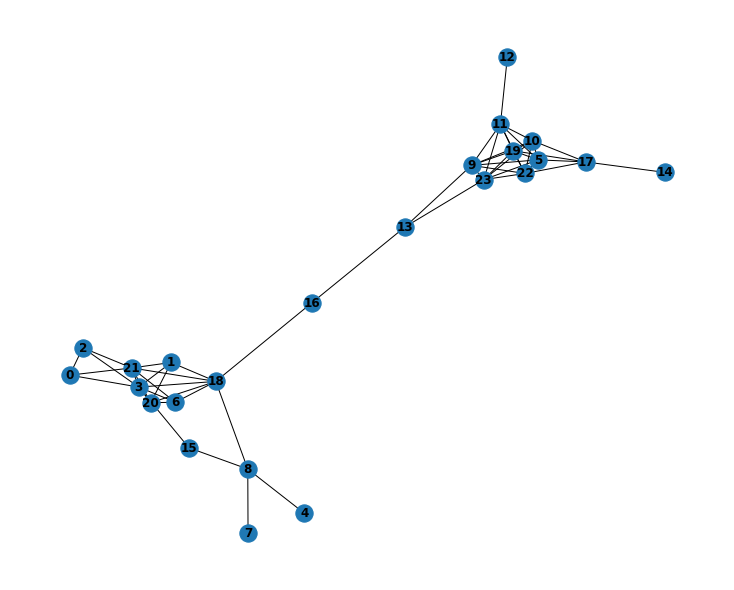

In [178]:
net = seq_graph.build_graph(edge_percent=0.2)
fig = plt.figure(1, figsize=(10, 8))
nx.draw(net, with_labels=True, font_weight='bold')
plt.show()

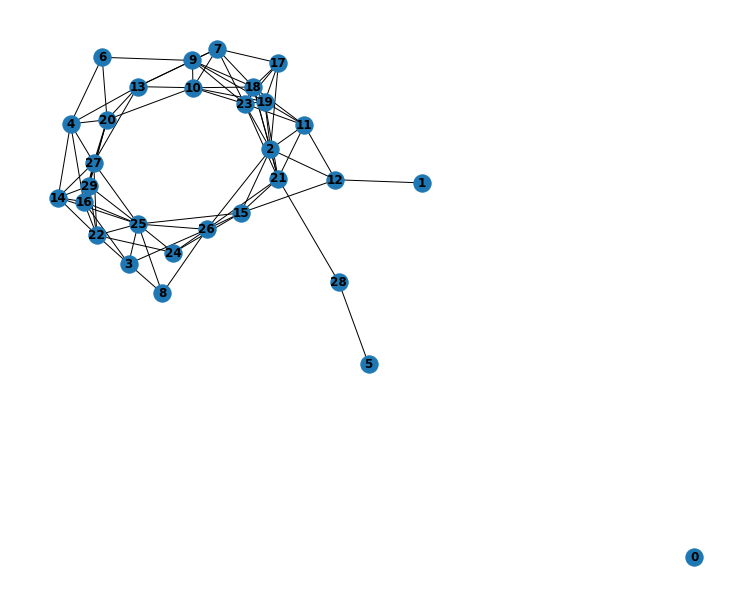

In [172]:
net = seq_graph.build_graph(edge_percent=0.2)
fig = plt.figure(1, figsize=(10, 8))
nx.draw(net, with_labels=True, font_weight='bold')
plt.show()

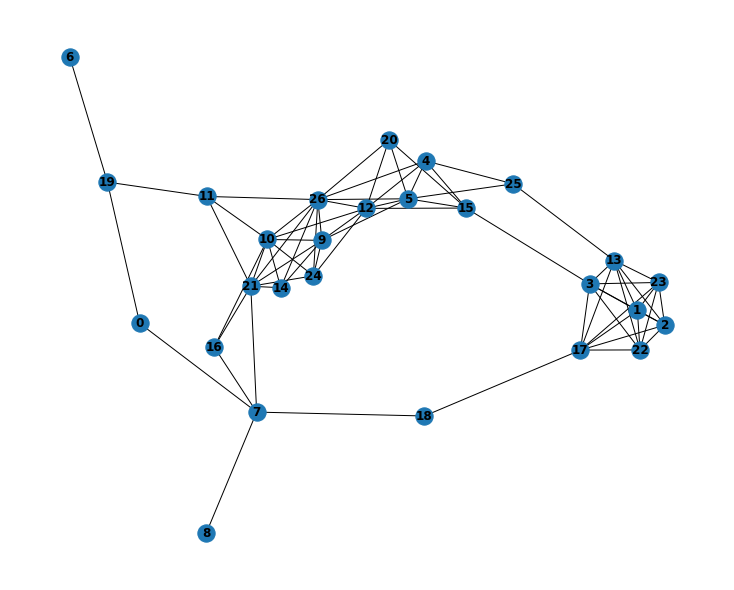

In [166]:
net = seq_graph.build_graph(edge_percent=0.2)
fig = plt.figure(1, figsize=(10, 8))
nx.draw(net, with_labels=True, font_weight='bold')
plt.show()